# GAHN ALIOUNE BADARA BA 


In [ ]:
import matplotlib.pyplot as plt  
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import re
import os
from sklearn.metrics import f1_score

In [363]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans

In [364]:
pathtest = '/fake-news-prediction-toulouse/data_competition/news/test/' #Path to train data directory
pathtrain = '/fake-news-prediction-toulouse/data_competition/news/training/' #Path to test data directory

## Chargement des données 

In [365]:
def indexation1(directory=pathtrain):
    listDoc = os.listdir(directory)
    df = pd.DataFrame(columns=['doc','body','title','lastphrases'])
    for fichier in listDoc:
        if re.match('[0-9]+',fichier[0:-4]) and fichier[-4:] == '.txt':
            # option encoding pour éviter les problèmes d'encodage 
            f = open(directory+fichier,'r',encoding = 'utf-8')
            numFichier = int(fichier[0:-4])
            f1 = [l.strip() for l in f]
            title = f1[0] 
            lastphrases = f1[len(f1)-1]
            body = ''
            for i in range(1,len(f1)):
                body = body+' '+ f1[i] 
            row = pd.Series([numFichier,body,title, lastphrases], index=df.columns)
            df = df.append(row, ignore_index=True, sort=False)
    
    df = df.sort_values(by=['doc'])
    df = df.reset_index(drop=True)
    
    # transformer le type de la colonne 'doc' afin qu'elle soit en int 64 pour pouvoir par la suite effectuer 
    # des jointures avec d'autres dataframes.
    df.doc = df.doc.astype(np.int64)
        
    return(df)

In [366]:
dftrain = indexation1()
dftest = indexation1(pathtest)

In [367]:
def sentense2cleanTokens(sent):
    sent = sent.lower()
    sent = "".join([x if (x.isalpha() ) else " " for x in sent])
    sent = " ".join(sent.split())
    return sent

# Nettoyage des données train et test

In [368]:
cleanbodystrain = [sentense2cleanTokens(x) for x in dftrain['body']]
cleanbodystest = [sentense2cleanTokens(x) for x in dftest['body']]
cleanphrases = [sentense2cleanTokens(x) for x in dftrain['lastphrases']]
cleanphrasestest = [sentense2cleanTokens(x) for x in dftest['lastphrases']]

# Etude sur les Features

In [369]:
# Fonction qui compte le nombre de majuscules dans un document
def countnbwordsmajuscules(df,attribute):
    liste = []
    for text in df[attribute].values:
        s = re.findall(" ([A-Z]+ )" , text)
        liste.append(len(s))
    return (liste)


Appliquons cette fonction sur nos données pour voir ce qu'on a :

In [370]:
majusculetitle = countnbwordsmajuscules (dftrain, 'title')
majusculebody = countnbwordsmajuscules( dftrain, 'body')
majusculelastphrase = countnbwordsmajuscules ( dftrain, 'lastphrases')

<Figure size 432x288 with 0 Axes>

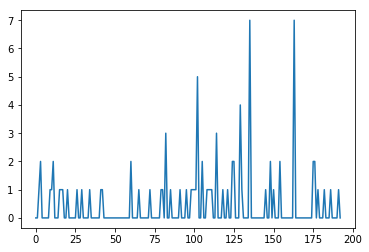

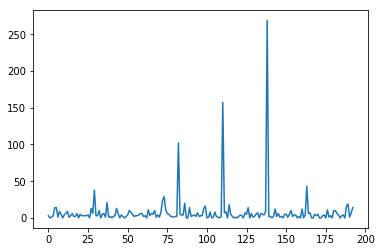

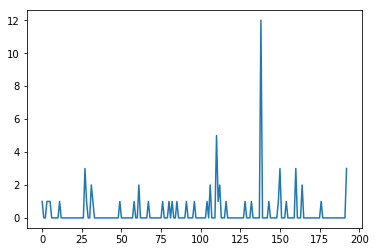

<Figure size 432x288 with 0 Axes>

In [371]:
plt.plot(dftrain.index, majusculetitle)
plt.figure()
plt.plot(dftrain.index, majusculebody)
plt.figure()
plt.plot(dftrain.index, majusculelastphrase)
plt.figure()

Ces trois sorties nous montrent que le nombre de mots en majuscule à tendance à etre plus elevé dans les fake news (id >112).
Cependant le feature est plus important dans les titres. Nous allons donc considerer cela que dans les titres.

In [372]:
#Construction du feature
majtrain = pd.DataFrame(countnbwordsmajuscules(dftrain,'title'), index = dftrain['doc'].values)
majtest = pd.DataFrame(countnbwordsmajuscules(dftest,'title'), index = dftest['doc'].values)
majtrain.insert(0, 'doc', majtrain.index)
majtrain.columns = ['doc', 'nbmajuscule']
majtest.insert(0, 'doc', majtest.index)
majtest.columns = ['doc', 'nbmajuscule']

In [373]:
dfxtrain = majtrain
dfxtest = majtest

In [374]:
# Fonction qui trouve un mots, on l'utilise pour renvoyer les documents qui ont des sources ou des authors
# On utilise ici des expressions régulières
def findword(cleancontent,patern):
    liste = []
    for i,text in enumerate (cleancontent):
        patern = patern
        val = re.findall(patern + ' [a-z]\w+', text)
        patern2 = patern+'s'
        val2 = re.findall(patern2 + ' [a-z]\w+', text)
        liste.append(len(val)+len(val2))
    return (liste)

In [375]:
sources = findword (cleanphrases, 'source')
authors  = findword (cleanphrases , 'author')

<Figure size 432x288 with 0 Axes>

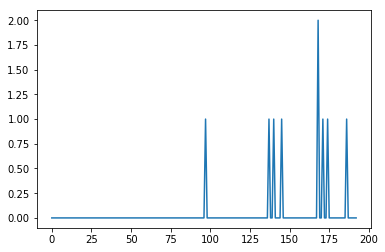

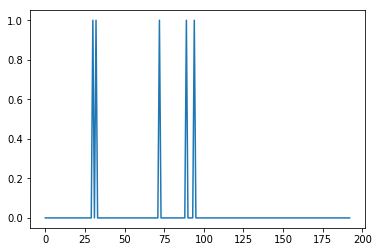

<Figure size 432x288 with 0 Axes>

In [376]:
plt.plot(dftrain.index, sources)
plt.figure()
plt.plot(dftrain.index, authors)
plt.figure()

Cette sortie nous montre que presque tous les documents sourcés sont des fakes news (id>112) , cependant c'est le contraire pour les auteurs. 
Ce qui est donc plausible. On a une trés bonne précision pour ce feature mais un trés petit rappel. 
On va donc pas les garder

In [377]:
# Fonction qui renvoit le nombre de guillemets dans un document 
def countnbguillemets(df, attribute):
    liste = []
    for text in df[attribute].values:
        liste.append(text.count('"') /2)
    return (liste)


<Figure size 432x288 with 0 Axes>

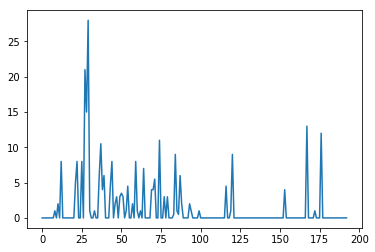

<Figure size 432x288 with 0 Axes>

In [378]:
citationsbody = countnbguillemets ( dftrain, 'body')
plt.plot(dftrain.index, citationsbody)
plt.figure()

Le graphe nous montre que le nombre de guillemets est un feature trés important. Les documents vrai en ont beaucoup (id < 112).
Tandis que peu sont les fakes news qui en ont

In [379]:
# Construction du feature:
guitrain = pd.DataFrame(countnbguillemets(dftrain,'body'), index = dftrain['doc'].values)
guitest = pd.DataFrame(countnbguillemets(dftest,'body'), index = dftest['doc'].values)
guitrain.insert(0, 'doc', guitrain.index)
guitrain.columns = ['doc', 'nb_citations']
guitest.insert(0, 'doc', guitest.index)
guitest.columns = ['doc', 'nb_citations']
dfxtrain = pd.merge(dfxtrain, guitrain, on = 'doc')
dfxtest = pd.merge(dfxtest, guitest, on = 'doc')

In [380]:
# Fonction qui nous renvoit le nombre de mentions (@)
def countnbmention(df):
    liste = []
    for text in df['body'].values:
        liste.append(text.count('@'))
    return (liste)

<Figure size 432x288 with 0 Axes>

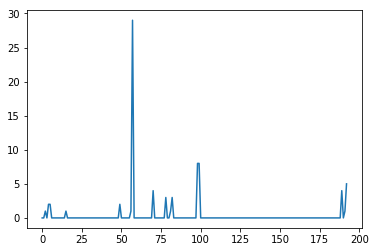

<Figure size 432x288 with 0 Axes>

In [381]:
mentions = countnbmention (dftrain)
plt.plot(dftrain.index, mentions)
plt.figure()

On voit que Peu de documents ont des mentions, on ne va donc pas garder ce feature 

# Clustering de Documents 

 Nous commencons par faire du Clustering pour voir si le regroupement par Thématique peut etre interessant pour nos prédictions

In [382]:
# Calcul du TfIdf pour le LSA
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, 
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(cleanbodystrain + cleanbodystest).toarray()
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [383]:
tfidf=pd.DataFrame(tfidf,columns=tfidf_vectorizer.get_feature_names(), index = list(dftrain['doc'].values) + list(dftest['doc'].values ))

Faisons une LSA sur le tf-idf obtenu 

In [384]:
svd = TruncatedSVD(n_components=100,  random_state=42)
dfsvd = pd.DataFrame (svd.fit_transform(tfidf), index = tfidf.index)
dfsvd

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1,0.189882,0.018715,0.023905,-0.018605,-0.045555,0.014495,0.048613,-0.015512,0.034214,0.073261,...,-0.112790,-0.031404,0.206688,-0.090686,-0.106095,-0.048497,-0.007786,-0.007950,0.066404,0.055622
3,0.145326,-0.051181,-0.025422,0.007975,-0.068755,-0.027029,-0.015464,0.068253,0.046562,0.041990,...,0.051507,-0.046390,0.024547,-0.085582,0.035560,-0.148777,-0.084569,-0.009973,-0.076540,0.013793
5,0.189406,0.138342,-0.036281,0.108617,-0.032319,-0.035690,-0.016565,0.010468,0.016553,-0.015838,...,-0.035325,0.014271,-0.093743,0.168848,-0.084278,-0.133409,0.065275,0.077501,0.024706,-0.086028
6,0.211067,0.069668,-0.026860,0.024858,-0.051345,0.010635,-0.023806,0.014781,-0.033832,-0.000060,...,0.028970,0.073929,-0.068565,0.180257,0.059159,-0.026397,-0.170789,-0.016680,-0.048490,-0.053342
8,0.267985,0.223113,-0.024572,0.110778,-0.195381,-0.086727,0.240355,-0.055040,0.221721,0.486071,...,-0.004596,-0.060478,-0.038745,-0.024862,-0.023281,-0.025467,-0.015339,0.035393,0.007092,0.010362
9,0.267985,0.223113,-0.024572,0.110778,-0.195381,-0.086727,0.240355,-0.055040,0.221721,0.486071,...,-0.004596,-0.060478,-0.038745,-0.024862,-0.023281,-0.025467,-0.015339,0.035393,0.007092,0.010362
10,0.147356,-0.098784,0.001891,-0.002305,-0.039689,0.048048,0.019885,-0.090116,-0.016814,-0.018331,...,-0.015840,-0.114748,0.078233,0.089795,-0.074339,-0.035148,0.045837,-0.017699,-0.067963,0.060874
11,0.298894,0.300081,-0.115942,0.180283,-0.074940,-0.101578,0.046880,0.032143,-0.010538,-0.031511,...,0.016749,-0.013962,0.092699,0.070217,0.024473,0.054498,-0.019509,0.041328,0.018517,0.051643
12,0.369716,0.310563,-0.127094,0.211101,0.009983,-0.061442,-0.063007,0.061174,-0.053432,-0.060974,...,0.005421,0.026910,-0.059162,-0.058058,-0.045876,-0.024708,-0.005641,-0.036002,0.049230,-0.049918
13,0.217411,0.017701,0.047215,-0.026646,-0.090610,0.007952,0.000708,-0.024221,-0.028465,0.008111,...,-0.113253,-0.093038,-0.110051,-0.127687,0.072025,-0.012877,0.013945,0.052553,0.008383,-0.047252


Faisons un K-Means sur ces données pour voir quel regroupement nous pouvons faire sur nos données

In [385]:
km1 = MiniBatchKMeans()
km1.fit(dfsvd)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=8,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [386]:
km1.labels_

array([4, 4, 5, 1, 0, 0, 1, 5, 5, 3, 4, 3, 2, 4, 5, 5, 4, 1, 4, 4, 3, 6,
       2, 4, 1, 4, 4, 5, 5, 4, 6, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 2, 6, 7,
       5, 4, 4, 7, 4, 4, 4, 5, 5, 2, 4, 5, 3, 4, 1, 7, 1, 4, 4, 7, 4, 2,
       5, 3, 5, 5, 5, 2, 5, 5, 5, 4, 2, 4, 4, 5, 4, 4, 5, 2, 3, 5, 3, 2,
       5, 5, 2, 4, 5, 6, 2, 6, 4, 4, 5, 4, 4, 4, 5, 4, 4, 1, 4, 2, 4, 4,
       3, 4, 4, 4, 4, 4, 1, 3, 1, 5, 4, 4, 4, 3, 3, 4, 4, 4, 1, 2, 4, 4,
       4, 4, 1, 4, 4, 4, 2, 4, 4, 1, 2, 2, 1, 4, 2, 2, 4, 4, 3, 4, 4, 4,
       1, 4, 3, 1, 5, 4, 4, 4, 4, 4, 4, 3, 2, 4, 4, 4, 4, 4, 4, 2, 1, 4,
       4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 6, 4, 5, 4,
       4, 2, 3, 1, 4, 4, 6, 5, 4, 1, 1, 4, 2, 1, 4, 4, 3, 2, 4, 4, 4, 4,
       2, 2, 4, 4, 3, 4, 4, 2, 4, 2, 2, 2, 4, 2, 4, 4, 4, 5, 4, 4],
      dtype=int32)

Les résultats nous retournent un nombre de clusters égal à 7. représentons les pour voir ce que ca va donner/

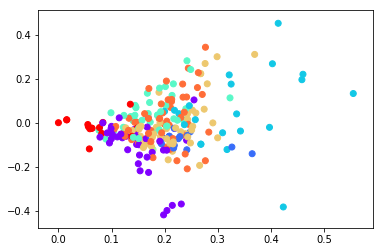

In [387]:
plt.scatter(dfsvd[0].values, dfsvd[1].values, c=km.labels_, cmap='rainbow') 

## Word2Vec

Vu que le contexte des documents nous semble important pour ce sujet, Nous allons Utiliser Word2Vec pour essayer de donner du sens à chaque docuement.
Pour Cela, nous allons dans un premier temps representer tous les mots par rapport à leur contexte en Utilisant un Word2Vec pré-entrainé par google avec plus de 3 millions de documents. 
Ensuite, pour chaque document nous allons le représenter par un vecteur de 300 colonnes en faisant la moyenne des représentations de chaque mots du document mais pondérée par le TF-IDF du mots dans le document.
Ensuite, nous appliquerons un K-Means pour essayer de faire des clusters de Documents:

In [388]:
import gensim
from gensim.models import Word2Vec

Importation du modèle téléchargé

In [402]:
# Veuillez mettre le chemin vers le word2vec téléchargé Svp
pathword2vec = '/home/sid2018-1/Bureau/GoogleNews-vectors-negative300-SLIM.bin' #Chemin du word2vec téléchargé de Google

In [389]:
# Load Google's pre-trained Word2Vec model.
#Ce code mets environ deux minute à tourner car le modèle est lourd
model = gensim.models.KeyedVectors.load_word2vec_format(pathword2vec, binary=True)  

 Renforcement du modèle sur nos données

In [390]:
#On crée un model de Taille 300 equivalent à la taille du modèle téléchargé en ligne
# Ce code aussi mets du temps à tourner
model_2 = Word2Vec(size=300, min_count=1) 
model_2.build_vocab(cleanbodystrain + cleanbodystest) #On construit le vocabulaire avec nos données train et test

total_examples = model_2.corpus_count

model_2.build_vocab([list(model.vocab.keys())], update=True)
model_2.intersect_word2vec_format(pathword2vec, binary= True) 
model_2.train(cleanbodystrain + cleanbodystest, total_examples=total_examples, epochs=model_2.iter) #On entraine notre modèle

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  # Remove the CWD from sys.path while we load stuff.


(2659600, 3633140)

Création des vecteurs de Documents

In [391]:
# Cette fonction prend en entrée le Tfidf et la sortie de l'entrainement du modèle pour créer pour chaque document 
# un vecteur de 300 colonnes représentation la moyenne pondérée par le TFIDF des Vecteurs des mots qui le composent
def vectorsdocument(tfidf, model):
    documents = {}
    for i in (tfidf.index):
        vecteur = np.zeros(300)
        for word in (tfidf.columns):
            if word in (model.wv.vocab):
                vecteur = tfidf[word][i] *  model[word] + vecteur
        documents[i] = vecteur
    return(documents)
            

In [392]:
vectorsdocument = vectorsdocument(tfidf,model_2)
vectorsdocument = pd.DataFrame.from_dict(vectorsdocument, orient='index')

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [393]:
vectorsdocument

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1,0.388763,0.205930,-0.224669,0.957172,-0.449969,-0.446355,-0.013716,-0.626432,1.185757,0.436509,...,-0.738002,0.136996,-0.738031,-0.037256,-0.045055,0.190717,-0.359271,-0.011512,0.530066,-0.139202
3,0.002798,0.225385,0.083148,0.097116,-0.122023,0.154865,0.364391,-0.469605,0.805891,-0.145291,...,-0.355588,0.070663,-0.800609,0.141893,-0.309186,-0.524286,0.173965,-0.465778,0.127197,0.186353
5,0.139781,0.309395,0.183838,0.597655,-0.714879,-0.340635,0.457017,-0.553324,0.762429,0.261057,...,-0.459009,0.063541,-0.697426,0.370550,-0.228133,-0.263732,0.017690,-0.431225,0.504884,0.278976
6,0.462669,0.350875,0.049474,0.441687,-0.475823,-0.425399,0.731335,-0.298349,0.994562,0.796359,...,-0.455469,-0.165689,-0.695279,0.343298,-0.178167,-0.425623,0.398651,-0.487241,0.249886,0.348951
8,0.355322,0.503978,0.211883,1.073663,-0.358732,-0.180728,0.508329,-0.450263,0.835015,0.639327,...,-0.774568,0.359761,-0.765310,0.200165,-0.321710,0.078142,0.204147,-0.738852,0.244157,-0.031297
9,0.355322,0.503978,0.211883,1.073663,-0.358732,-0.180728,0.508329,-0.450263,0.835015,0.639327,...,-0.774568,0.359761,-0.765310,0.200165,-0.321710,0.078142,0.204147,-0.738852,0.244157,-0.031297
10,0.529031,0.431899,-0.208447,0.393184,-0.378841,-0.326951,0.274703,-0.760804,0.801091,0.356985,...,-0.319241,0.175180,-0.948584,0.109274,0.083242,-0.122680,-0.065770,-0.151389,0.159317,-0.005674
11,0.358314,0.620613,0.013323,0.523487,-0.344457,-0.219890,0.228152,-0.575918,0.791680,0.733692,...,-0.209606,0.230912,-0.404107,-0.022131,-0.437156,-0.379758,0.192469,-0.737998,-0.081700,0.193559
12,-0.044330,0.535712,0.105971,0.630470,-0.419313,-0.579153,0.029158,-0.745648,0.678003,0.426907,...,-0.280247,-0.076742,-0.411693,-0.023266,-0.165606,-0.666447,-0.104168,-0.672197,-0.141526,0.138665
13,0.259045,0.346787,0.269716,0.627243,-0.359844,-0.257814,0.071143,-0.440117,0.459311,0.182864,...,-0.460981,0.274060,-0.914306,0.170686,-0.184429,-0.353803,0.584533,-0.284914,0.414355,-0.053628


Pour chaque document, nous avons maintenant 300 dimensions. Notre intuition est de faire une ACP pour voir si il n'ya pas de
dimensions qui expliquent plus de pourcentages d'inertie afin d'avoir une meilleure classification en faisant le K- Means

In [394]:
from sklearn.decomposition import PCA
X = vectorsdocument
pca = PCA(n_components=239)
pca.fit(X)
print(pca.explained_variance_ratio_)

[2.52249079e-01 8.01824094e-02 6.02921874e-02 4.51002030e-02
 3.68189185e-02 3.04428755e-02 2.51784335e-02 2.14795930e-02
 2.03266100e-02 1.86747908e-02 1.65787072e-02 1.41750197e-02
 1.29930917e-02 1.19931546e-02 1.12280972e-02 1.03116187e-02
 9.56904724e-03 8.91143921e-03 7.86129016e-03 7.44380135e-03
 7.20828483e-03 6.92754764e-03 6.85664424e-03 6.53001435e-03
 6.19143061e-03 5.92922428e-03 5.81410684e-03 5.66854953e-03
 5.42814301e-03 5.30231866e-03 5.13209660e-03 5.07431785e-03
 4.90020595e-03 4.81665421e-03 4.63435034e-03 4.53440076e-03
 4.48218449e-03 4.29977359e-03 4.12261107e-03 4.06555147e-03
 3.97120388e-03 3.88068037e-03 3.85332495e-03 3.72669091e-03
 3.63888252e-03 3.46613162e-03 3.37774675e-03 3.35074305e-03
 3.33611187e-03 3.19090036e-03 3.14320140e-03 3.05468626e-03
 3.01045647e-03 2.91962273e-03 2.90587327e-03 2.82955802e-03
 2.79043483e-03 2.69367538e-03 2.67525216e-03 2.59467152e-03
 2.53689041e-03 2.46276582e-03 2.42914688e-03 2.38557572e-03
 2.37384510e-03 2.323430

Nous voyons donc que toutes les dimensions contribuent faiblement à l'inertie. Mais l'écart entre leurs contributions est significative: On peut donc restreindre notre étude sur les 100 premieres dimensions (les plus explicatives) pour pouvoir comparer nos résultats avec la méthode LSA

### K-Means sur les documents

In [395]:
km = MiniBatchKMeans()
km.fit(vectorsdocument)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=8,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [396]:
km.labels_

array([3, 3, 2, 2, 1, 1, 7, 2, 2, 3, 0, 5, 7, 3, 3, 3, 3, 7, 5, 3, 2, 7,
       0, 6, 0, 6, 3, 6, 2, 6, 1, 3, 4, 6, 3, 3, 3, 0, 2, 3, 3, 2, 2, 6,
       2, 3, 3, 0, 2, 3, 6, 3, 3, 0, 2, 3, 2, 2, 0, 6, 0, 3, 3, 2, 3, 3,
       4, 2, 3, 3, 3, 0, 6, 4, 2, 5, 5, 3, 3, 3, 3, 6, 4, 3, 1, 3, 2, 0,
       3, 4, 0, 2, 2, 7, 5, 7, 0, 2, 3, 3, 3, 0, 2, 0, 3, 3, 0, 1, 1, 3,
       1, 2, 1, 2, 2, 7, 0, 3, 6, 3, 2, 0, 1, 3, 2, 1, 1, 3, 7, 7, 3, 7,
       0, 3, 7, 0, 2, 3, 5, 3, 3, 3, 7, 7, 0, 1, 7, 7, 3, 6, 1, 3, 0, 3,
       7, 7, 2, 7, 2, 3, 0, 2, 1, 4, 3, 1, 7, 3, 0, 1, 3, 1, 3, 7, 3, 7,
       0, 7, 0, 3, 5, 2, 3, 2, 1, 2, 0, 2, 1, 2, 3, 2, 7, 2, 7, 2, 2, 3,
       0, 7, 2, 7, 6, 6, 4, 3, 3, 6, 0, 5, 7, 1, 4, 2, 6, 0, 2, 1, 2, 2,
       7, 7, 3, 0, 7, 2, 7, 3, 3, 7, 7, 7, 7, 7, 1, 7, 3, 7, 1, 7],
      dtype=int32)

Notre remarque est que le K-Means aussi nous donne 7 Clusters comme la NMF et à 1 cluster prés du LDA

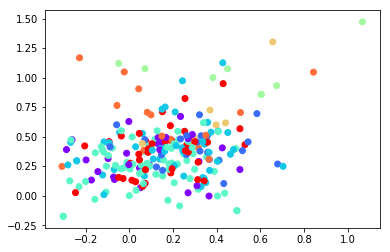

In [397]:
plt.scatter(vectorsdocument[0].values, vectorsdocument[1].values, c=km.labels_, cmap='rainbow')  

### Comparaison LSA + KMEANS VS WORD2VEC + KMEANS

Sur nos deux sorties des K-Means sur la LSA et Sur le Word2Vec , nous voyons que sur un meme nombre de dimensions (100), 
le regroupement par thématique se fait sur 7 topics différents. Cependant, c'est le word2vec qui nous donne la meilleure classification. donc nous allons le garder

In [398]:
dfw2v = pd.DataFrame(km.labels_, index = vectorsdocument.index)
dfw2v.insert(0, 'doc', dfw2v.index)
dfw2v.columns = ['doc', 'classdoc']

In [399]:
dfxtrainw2v = pd.merge(dfw2v, dfxtrain, on = 'doc')
dfxtestw2v = pd.merge (dfw2v, dfxtest, on ='doc')

In [400]:
dfxtrain = dfxtrainw2v
dfxtest = dfxtestw2v

##### On sauvegarde notre dataframe de features text en csv et on va les combiner avec nos features Nertwork pour faire nos prédictions.

In [401]:
pathdfxtrain= '/xtraintext.txt'
pathdfxtest = '/xtesttext.txt'
dfxtrain.to_csv(pathdfxtrain, index=False, header=1)
dfxtest.to_csv(pathdfxtest, index=False, header=1)